In [4]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
class LinUCB:
    def __init__(self, action_set, dim=2, lamb=1, T=1000):
        self.theta_t = np.random.rand(dim)
        self.action_set = action_set
        self.round_idx = 0
        self.Vs = [lamb * np.identity(dim)]
        self.actions = []
        self.rewards = []
        self.T = T
        self.dim = dim
        
    def compute(self):
        beta = self.compute_beta(self.round_idx)
        action_set = np.asarray(self.action_set)
        #<theta, a>
        measured_val = np.dot(action_set, self.theta_t)
        
        #a^TV
        AV = np.dot(action_set, np.linalg.pinv(self.Vs[-1]))
        
        #<theta, a> + a^TVa * sqrt(beta) 
        measured_val += math.sqrt(beta) * np.diagonal(np.dot(AV, action_set.T))
        
        #Picks best action from all set of those
        idx_best_action = np.argmax(measured_val)
        best_action = action_set[idx_best_action]
        self.Vs.append(np.dot(np.transpose(np.expand_dims(best_action, axis=0)), np.expand_dims(best_action, axis=0)) + self.Vs[-1])
        self.actions.append(best_action)
        return best_action
    
    def observe_reward(self, reward):
        
        self.rewards.append(reward)
        rewards_arr = np.expand_dims(np.asarray(self.rewards).T, axis=0)
        actions_arr = np.asarray(self.actions)
        
        sigma = np.sum(np.dot(rewards_arr, actions_arr), axis=0)
        self.theta_t = np.dot(np.linalg.pinv(self.Vs[-1]), sigma.T).squeeze()
        
    def compute_beta(self, t):
        return 1 + math.sqrt(2*math.log(self.T) + self.dim * math.log((self.dim+self.T)/self.dim))
    
    


In [6]:
class UCB:
    def __init__(self, action_set, dim=2,T=1000):
        self.action_set = action_set
        self.T = T
        self.alpha = 1/(T*T)
        self.sample_means = np.asarray([0.0] * dim)
        self.confidence_widths = np.asarray([np.inf] * dim)
        self.num_pulls = np.asarray([0] * dim)
        self.actions = []
        self.action_idxs = []
        
    def compute(self):
        index = np.argmax(self.sample_means + self.confidence_widths)
        self.num_pulls[index] += 1
        self.action_idxs.append(index)
        self.actions.append(self.action_set[index])
        return self.action_set[index]
    
    def observe_reward(self, reward):
        cur_mean = self.sample_means[self.action_idxs[-1]]
        num_samples = self.num_pulls[self.action_idxs[-1]] - 1
        new_mean = (cur_mean * num_samples + reward)/(num_samples + 1)
        self.sample_means[self.action_idxs[-1]] = new_mean[0]
        self.confidence_widths = np.sqrt(2*(math.pow(self.T, self.alpha) - 1)/(self.alpha * self.num_pulls))
        
                        
        
        
         

In [7]:
def calc_pseudoregret(theta, actions):
    diff = theta - np.max(theta)
    new_actions = np.stack(actions, axis=0)
    return -np.sum(np.dot(new_actions, theta))

In [110]:
class Oracle:
    def __init__(self, theta):
        self.theta = theta
        
    def compute_reward(self, action):
        rewards = np.inner(action, self.theta) + np.random.normal(0, 1, 1)
        return rewards


In [52]:
def train_alg(alg, T, theta):
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)
    return calc_pseudoregret(theta, alg.actions)

In [10]:
delta = .5
T = 1000
dim = 2
lamb = 1
theta = np.asarray([0, -delta])
oracle = Oracle(theta)
action_set = [np.eye(1,dim,index).squeeze() for index in range(dim)]
all_regrets = []
for delta in np.linspace(0, 1, num=20):
    delta_regrets = []
    theta = np.asarray([0, -delta])
    for epoch in tqdm(range(100)):
        alg = LinUCB(action_set)
        delta_regrets.append(train_alg(alg, T, theta))
    all_regrets.append(np.mean(delta_regrets))


100%|█████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


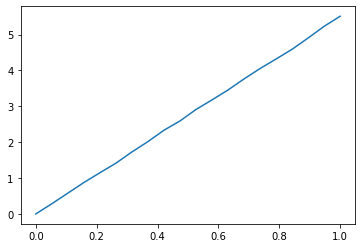

In [14]:
plt.plot(np.linspace(0, 1, num=20), all_regrets)

In [639]:
delta = .5
T = 1000
dim = 2
lamb = 1
theta = np.asarray([0, -delta])
oracle = Oracle(theta)
alg = LinUCB()
action_set = 
ucb_all_regrets = []
for delta in np.linspace(0, 1, num=20):
    delta_regrets = []
    theta = np.asarray([0, -delta])
    for epoch in tqdm(range(100)):
        alg = UCB()
        delta_regrets.append(train_alg(alg, T, theta))
    ucb_all_regrets.append(np.mean(delta_regrets))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/var/folders/j0/12_hmkfx6bx04_ymlhscx4t80000gp/T/ipykernel_15424/3338656.py:24: RuntimeWarning: divide by zero encountered in true_divide
  self.confidence_widths = np.sqrt(2*(math.pow(self.T, self.alpha) - 1)/(self.alpha * self.num_pulls))
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 50.99it/s]


NameError: name 'ucb_all_regrets' is not defined

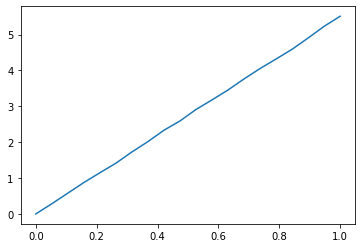

In [13]:
plt.plot(np.linspace(0, 1, num=20), all_regrets, label="linucb")
plt.plot(np.linspace(0, 1, num=20), ucb_all_regrets, label="ucb")
plt.show()

In [92]:
def generate_k_dim_vector(dim=2):
    vec = np.random.random(int(dim)) * 2 - 1
    return vec

In [26]:
T = 5000
dim = 5
lamb = 1
theta = np.asarray([4, 3, 2, 1, 0]) * 1/math.sqrt(30)
oracle = Oracle(theta)
linucb_all_regrets = []
ucb_all_regrets = []
for k in np.linspace(2, 1000, num=10):
    lu_sub_regrets = []
    u_sub_regrets = []
    
    action_set = np.asarray([generate_k_dim_vector(dim) for _ in range(1000)])
    for epoch in tqdm(range(100)):
        ucb_alg = UCB(action_set, dim=dim, T=T)
        linucb_alg = LinUCB(action_set, dim=dim, T=T)
        u_sub_regrets.append(train_alg(ucb_alg, T, theta))
        lu_sub_regrets.append(train_alg(linucb_alg, T, theta))
    ucb_all_regrets.append(np.mean(u_sub_regrets))
    linucb_all_regrets.append(np.mean(lu_sub_regrets))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/var/folders/j0/12_hmkfx6bx04_ymlhscx4t80000gp/T/ipykernel_47161/1540945954.py:24: RuntimeWarning: divide by zero encountered in true_divide
  self.confidence_widths = np.sqrt(2*(math.pow(self.T, self.alpha) - 1)/(self.alpha * self.num_pulls))
  2%|▊                                          | 2/100 [00:03<02:27,  1.51s/it]


KeyboardInterrupt: 

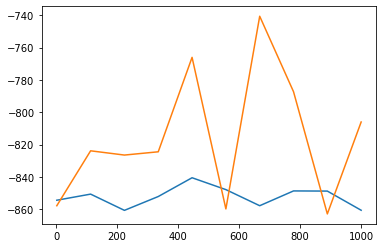

In [690]:
plt.plot(np.linspace(2, 1000, num=10), linucb_all_regrets, label="linucb")
plt.plot(np.linspace(2, 1000, num=10), ucb_all_regrets, label="ucb")
plt.show()

In [101]:
def plot_vectors(theta, actions):
    plt.axis([-1, 1, -1, 1])
    plt.quiver(0, 0, theta[0], theta[1], color='green', scale=1)
    for idx, action in enumerate(actions):
        plt.quiver(0, 0, action[0], action[1], color = [(idx/len(actions), 0, 0)], scale=1)

In [123]:
delta = .5
T = 50
dim = 5
lamb = 1
theta = np.asarray([.5, -.25, .33, -.125, .8])
oracle = Oracle(theta)
action_set = np.asarray([generate_k_dim_vector(dim) for _ in range(1000)])
alg = LinUCB(action_set, dim=dim)
delta_regrets.append(train_alg(alg, T, theta))
# plot_vectors(theta, [alg.actions[-1]])
print(alg.actions[-1])

[ 0.88971054 -0.77089805  0.9181751  -0.85904823  0.83919753]


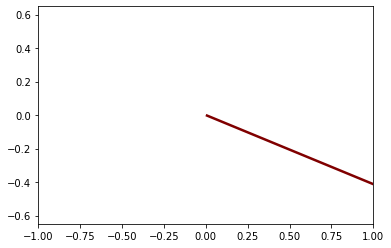

In [116]:
x = np.linspace(0,1,11)
y = np.linspace(1,0,11)
u = v = np.zeros((11,11))
u[5,5] = 0.2
plt.axis('equal')
plt.axis([-1, 1, -1, 1])
plt.quiv
er(0,0, .8, -.33,  color=[(.5, 0, 0)], scale=1)

In [ ]:
#Change action set to boundaries
#Check how two thetas with same optimal actions will have different action sequences
#Why are these different? How will these differ?
#Choose different colors and figure out the scale
#check about frequency of "pulls", sum the action sequence!
#Candidate values of theta: alternating signs (like with 0.9, 0.5 as values, a lot of coordinates should differ), alternating signs with only one coord differs
#Exploratory: If you were just solving mab, can you formulat an alternative estimator that is a solution to an lp
#Exploratory: decision variables are unknown means where you have to solve, and every time an arm is pulled, you get a constraint
# You also get other constraints that when an arm is not pulled, you get an equality constraint
#so look at the end of the horizon, and get the lp from there